# Following trends on Twitter

[1. Abstract](#Abstract)

[2. Exploratory data analysis](#Exploratory-data-analysis)

[3. Topic Modeling using LDA](#A-very-simple-Topic-Modeling-using-LDA)

[4. Example of the pipeline](#Example-of-the-pipeline-that-we-will-follow-for-the-LDA-algorithm)

[5. Milestone 3](#Milestone-3:-the-data-story)

# Abstract


We realiazed that it will be hard to achieve the goal stated in milestone 1(detecting fake news). The problem is that we couldn't find a way to define fake news. And also the twitter dataset is not what we expected it to be. For example it doesn't contain the number of times a tweet has been retweeted, the geographical location, number of likes ... So we decided to go in a different, more feasable direction, which is following the process of creating and spreading trends on Twitter. Trying to find patterns between trends and users. 

In [6]:
import numpy as np
import json
import re
import matplotlib.pyplot as plt
from pyspark.sql import *
from pyspark import SparkContext, SQLContext
from pyspark.ml.feature import *
from pyspark.mllib.clustering import LDA, LDAModel
from pyspark.sql import functions as F
import pickle
import nltk
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import string
import warnings
import ast
warnings.filterwarnings("ignore")
%matplotlib inline  

#### Read data

> Each data entry has 5 fields:
     - language: language of the user 
     - id: id of the user
     - date: date when the tweet was published
     - username: username of the user
     - content: the tweet
     
Given that for the moment we consider only rows that have all 5 fields we don't have to deal with missing values.
     

In [2]:
sqlContext = SQLContext(sc)
data = sc.textFile("/datasets/tweets-leon")

# Exploratory data analysis

> 1 We will first clean the data and select only a subset that is useful for this project:
    - keep only the tweets that have all 5 fields
    - remove urls from the content
    - remove emojis
    - remove punctuation 
    - remove stopwords
    - apply lemmatization 
    - keep only english, spanish and french tweets
    - ...

In [3]:
frist_tweet = data.first()
frist_tweet.split('\t')[2]

u'Sat Jun 15 18:00:01 +0000 2013'

In [24]:
frist_tweet.split('\t')[2].split(' ')[1]

u'Jun'

In [44]:
"""Chose tweets that have exactly 5 components like normal 
         (language, id, date, username, content)"""

def selection_tweet(tweet):
    array = tweet.split("\t")
    if (array[0] == 'en' and array[2][-4:]=='2014'):
        if ('RT' not in array[4]):
            return True
    return False

In [45]:
"""Remove punctuation, hashtags and urls"""

table = string.maketrans("","")
def punctuation(s):
    s = re.sub(r"@\S+", "", s)     #mention
    s = re.sub(r"http\S+", "", s)  #urls
    s = re.sub(r"#\S+", "", s)     #hashtag
    return s.translate(table, string.punctuation)

In [47]:
"encode tweet by mapping"

def encode_tweet(tweet):
    "Encode UTF-8"
    encoded = [t.encode("utf8") for t in tweet.split("\t")]
    "Remove punctuation and urls"
    encoded[4] = punctuation(encoded[4])
    "Lemmatization"
    encoded[4]= lemmatization(encoded[4])
    "Return id and content of tweet"
    return [encoded[1], encoded[4]]

In [48]:
precessed_data = data.filter(selection_tweet) \
                     .map(encode_tweet)

In [ ]:
hum = precessed_data.first()

Later on using the filter function as done below we will select only a useful subset of the data

In [9]:
"""select a subset of the data"""

data = data.filter(selection_tweet)

en_data = data.filter(lambda x : x[:2]=='en')
es_data = data.filter(lambda x : x[:2]=='es')
fr_data = data.filter(lambda x : x[:2]=='fr')

data_2012 = data.filter(lambda tweet : 
                        encode_tweet(tweet)[2][-4:] == '2012')
data_2013 = data.filter(lambda tweet : 
                        encode_tweet(tweet)[2][-4:] == '2013')


In [ ]:
some_fr_tweets = fr_data.take(5)
some_fr_tweets

In [ ]:
some_fr_tweets = [encode_tweet(tweet) for tweet in some_fr_tweets]

In [ ]:
print 'Some french tweets:'
for ind, t in enumerate(some_fr_tweets):
    print ind + 1,')User name:',t[3]
    print '         Tweets:', ((t[4]))
    print '         at:', t[2]
    print 

# A very simple Topic Modeling using LDA

In order to familiarize ourselves with the dataset we started with a very simple approach for topic extraction. For achieving this we will use the Latent Dirichlet allocation algorithm. We first need to build the tf-idf matrix using our data and then then pass it as a parameter to the LDA method. We also need to specify the number of topics to be extracted from the dataset, α(parameter of the Dirichlet prior on the per-document topic distributions) and β(parameter of the Dirichlet prior on the per-topic word distribution). We will determine this values in the next milestone. 

In [ ]:

"""Data in english and encode UTF-8"""
en_data = data.filter(selection_tweet).map(encode_tweet)

"""Take only ID and CONTENT of a tweet"""
tweets = en_data.map(lambda tweet : Row(id=tweet[0], sentence=tweet[1]))

"""Create DF"""
df_tweets = sqlContext.createDataFrame(tweets)

df_tweets.show(3)

In [30]:
"""Tokenization"""
regexTokenizer = RegexTokenizer(inputCol="sentence", outputCol="raw", pattern="\\W")
regexTokenized = regexTokenizer.transform(df_tweets)

regexTokenized.show(3)

+------------------+--------------------+--------------------+
|                id|            sentence|                 raw|
+------------------+--------------------+--------------------+
|345963923251539968|RT @silsilfani: t...|[rt, silsilfani, ...|
|345963923297673217|RT @WhosThisHoe: ...|[rt, whosthishoe,...|
|345963923259924480|Can't stand peopl...|[can, t, stand, p...|
+------------------+--------------------+--------------------+
only showing top 3 rows



In [ ]:
with open("regexTokenized.pickle", "wb") as f:
    pickle.dump(regexTokenized, f)

In [31]:
"""Remove Stop-words"""
remover = StopWordsRemover(inputCol="raw", outputCol="filtered")
removed_stopwords = remover.transform(regexTokenized)
with open("removed_stopwords.pickle", "wb") as f:
    pickle.dump(removed_stopwords, f)
removed_stopwords.show(3)

+------------------+--------------------+--------------------+--------------------+
|                id|            sentence|                 raw|            filtered|
+------------------+--------------------+--------------------+--------------------+
|345963923251539968|RT @silsilfani: t...|[rt, silsilfani, ...|[rt, silsilfani, ...|
|345963923297673217|RT @WhosThisHoe: ...|[rt, whosthishoe,...|[rt, whosthishoe,...|
|345963923259924480|Can't stand peopl...|[can, t, stand, p...|[t, stand, people...|
+------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [ ]:
"""apply lemmatization and remove punctuation"""


 Warning: Computation of TF-IDF and LDA take a lot of time (6h on the cluster, we don't know what's happening, why it takes so long ? Could you take a look at our code to see if maybe there is a problem with it). This is the reason why we have an extra python file (LDA.py) to submit to the cluster for the computation. 

In [ ]:
"""TF-IDF"""

cv = CountVectorizer(inputCol="filtered", outputCol="vectors")
count_vectorizer_model = cv.fit(removed_stopwords)
tf = count_vectorizer_model.transform(removed_stopwords)

idf = IDF(inputCol="vectors", outputCol="tfidf")
idfModel = idf.fit(tf)
tfidf = idfModel.transform(tf)

tfidf.show(3)

In [ ]:
"""Topics extraction with LDA"""

nbTopics=100
n_terms=15

corpus = tfidf.select(F.col('id').cast("long"), 'tfidf').rdd.map(lambda x: [x[0], x[1]])
ldaModel = LDA.train(corpus, k=nbTopics)


topics = ldaModel.describeTopics(maxTermsPerTopic=n_terms)
vocabulary = count_vectorizer_model.vocabulary

"""Store result"""
with open("topics.pickle", "wb") as f:
    pickle.dump(topics, f)
with open("vocabulary.pickle", "wb") as f:
    pickle.dump(vocabulary, f)   

In [ ]:
"""Load result computed from cluster"""

with open("topics.pickle", "rb") as f:
    topics = pickle.load(f)
    
with open("vocabulary.pickle", "rb") as f:
    vocabulary = pickle.load(f)

In [ ]:
for topic in range(len(topics)):
    print("topic {} : ".format(topic))
    words = topics[topic][0]
    scores = topics[topic][1]
    for word in range(len(words)):
        print(vocabulary[words[word]], "-", scores[word])

In [ ]:
topics = sc.textFile("/user/khau/topics.pickle")
vocabulary = sc.textFile("/user/khau/vocabulary.pickle")

In [5]:
def plot_topics(topics, vocabulary, nbTopics, n_terms):
    topic_scores = [x[1] for x in topics] #all scores
    max_score = np.max(topic_scores)
    nbColsPlot = 4
    MAGIC_NUMBER = 50
    fontsize_init = MAGIC_NUMBER / max_score

    for topic in range(len(topics)):
        plt.subplot(1, nbColsPlot, topic%4 + 1)
        plt.ylim(0, num_top_words + 0.5)
        plt.xticks([]) 
        plt.yticks([])
        plt.title('Topic #{}'.format(topic+1))
        words = topics[topic][0]
        scores = topics[topic][1]
        for word in range(len(words)):
            font_size = fontsize_init*scores[word]
            font_size = min(font_size, MAGIC_NUMBER)
            plt.text(0.05, num_top_words-word-0.5, vocabulary[words[word]], fontsize=font_size) 
    plt.tight_layout()
    plt.show()
    
plot_topics(topics, vocabulary, nbTopics=20, n_terms=10)

NameError: name 'topics' is not defined

# Milestone 3


In [2]:
"Load data"
data = sc.textFile("/datasets/tweets-leon")

In [3]:
"""Select tweet by filtering, keep only english tweets from 2014 having all 5 fields"""
def selection_tweet(tweet):
    array = tweet.split("\t")
    if (len(array)==5):
        if (array[0] == 'en' and array[2][-4:]=='2014'):
            return True
    return False

data_2014 = data.filter(selection_tweet)

# 1) Some statistics about data (2014)

In [ ]:
"spark-submit for the computation (stats.py)"
tweet_count = data_2014.map(lambda tweet: (tweet.split('\t')[2].split(' ')[1], 1)) \
                       .reduceByKey(lambda a, b: a + b) \
                       .sortBy(lambda wc: -wc[1])

counts = sqlContext.createDataFrame(tweet_count.map(lambda wc: Row(month=wc[0], count=wc[1])))

counts.show()

# save to json
counts.write.json("tweets_count.txt")

In [51]:
tweets_count = sc.textFile('/user/khau/tweets_count.txt')
tweets_count = tweets_count.collect()
tweets_count

[u'{"count":360042745,"month":"Jan"}',
 u'{"count":292583603,"month":"Dec"}',
 u'{"count":274942295,"month":"Mar"}',
 u'{"count":247174867,"month":"Feb"}',
 u'{"count":212186528,"month":"Jun"}',
 u'{"count":158177560,"month":"Apr"}',
 u'{"count":88703791,"month":"May"}',
 u'{"count":43743119,"month":"Aug"}',
 u'{"count":41006717,"month":"Nov"}',
 u'{"count":40601380,"month":"Oct"}',
 u'{"count":40263598,"month":"Sep"}',
 u'{"count":18825682,"month":"Jul"}']

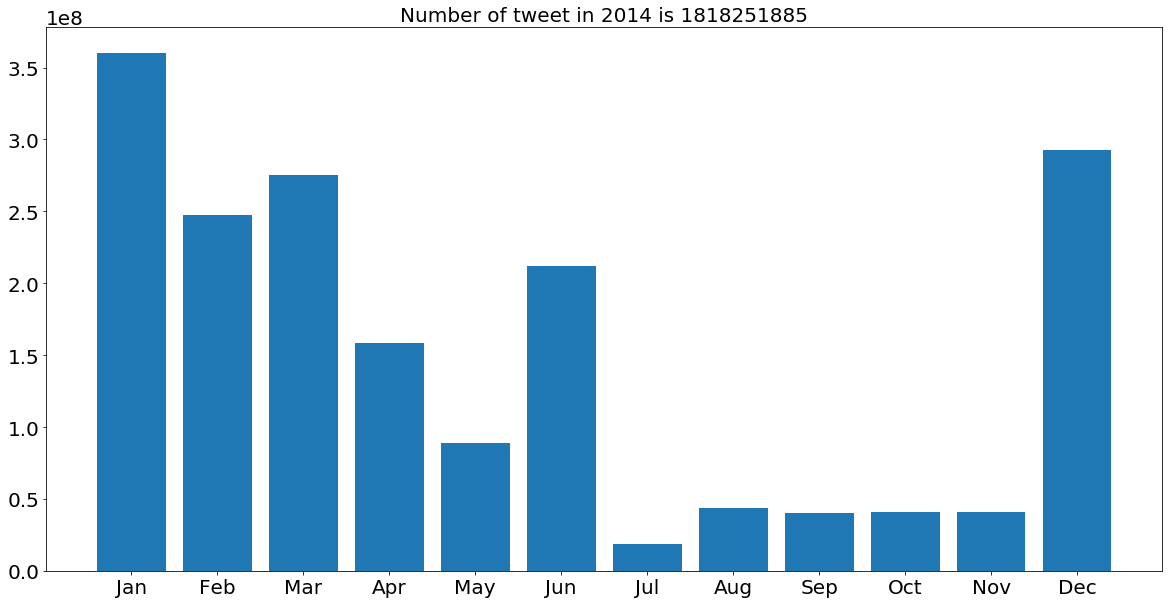

In [50]:
months = ['Jan', 'Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
counts = [360042745, 247174867, 274942295, 158177560,  88703791, 212186528,
          18825682, 43743119, 40263598, 40601380,  41006717, 292583603]
indexes = np.arange(12) + 1
SMALL_SIZE = 20
plt.rc('font', size=SMALL_SIZE)
plt.figure(figsize=(20,10))
plt.bar(indexes, counts)
plt.xticks(indexes, months)
plt.title('Number of english tweets in 2014 (on this dataset) is '+ str(np.sum(counts)))
plt.show()

# 2) Syntactical analysis

## A) Hashtag clustering

In [20]:
"""Extract hashtas from a tweet"""
def extract_hash_tags(tweet):
    encoded = [t.encode("utf-8") for t in tweet.split("\t")]
    return [(part[1:], 1) for part in encoded[4].split() if part.startswith('#')]

In [ ]:
"spark-submit for the computation (HTcount.py)"

hashtags = data_2014.map(extract_hash_tags)

hashtag_counts = hashtags.flatMap(extract_hash_tags) \
                         .reduceByKey(lambda a,b : a + b)\
                         .sortBy(lambda wc: -wc[1])
        
hashtag_counts = sqlContext.createDataFrame(hashtags.map(lambda wc: Row(hashtag=wc[0], count=wc[1])))

hashtag_counts.show()

# save to json
hashtag_counts.write.json("hashtag_counts.txt")

In [4]:
hashtag_counts = sc.textFile('/user/khau/hashtag_counts.txt')
hashtag_counts.take(5)

[u'{"count":4461004,"hashtag":"gameinsight"}',
 u'{"count":2352313,"hashtag":"KCA"}',
 u'{"count":1987323,"hashtag":"openfollow"}',
 u'{"count":1881818,"hashtag":"androidgames,"}',
 u'{"count":1823624,"hashtag":"MTVStars"}']

In [5]:
top_hashtags = hashtag_counts.map(json.loads)
nbHashTags   = top_hashtags.map(lambda x : x['count']) \
                           .sum()

In [6]:
hashtags_frequency = top_hashtags.take(1000)
hashtags_frequency = [(ht['count']/float(nbHashTags) , ht['hashtag'].encode('utf-8')) for ht in hashtags_frequency]

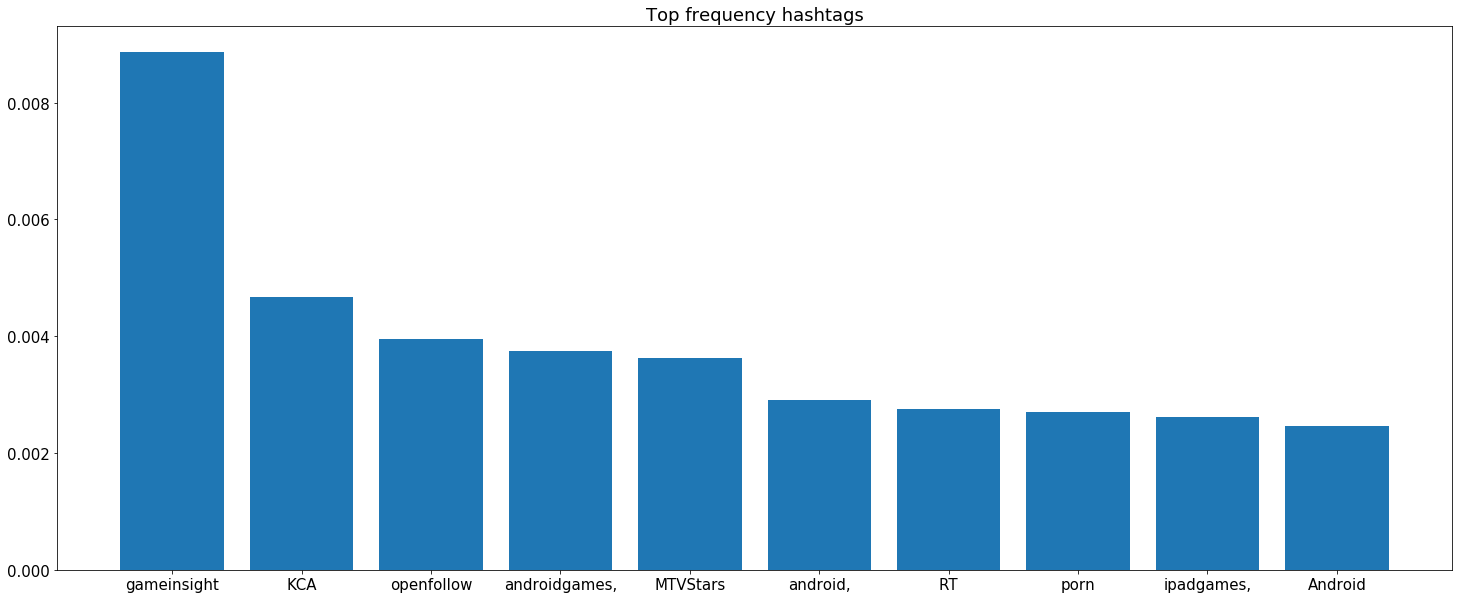

In [19]:
nbTake = 10
indexes = np.arange(nbTake) + 1
plt.rc('font', size=15)
plt.figure(figsize=(25,10))
x = [ elem[0] for elem in hashtags_frequency[:nbTake]]
y = [ elem[1] for elem in hashtags_frequency[:nbTake]]
plt.bar(indexes, x)
plt.xticks(indexes, y)
plt.title('Top frequency hashtags in 2014')
plt.show()

## B) Top terms frequencies

In [28]:
"""Remove punctuation, hashtags and urls"""
table = string.maketrans("","")
def punctuation(s):
    s = re.sub(r"@\S+", "", s)     #mention
    s = re.sub(r"http\S+", "", s)  #urls
    s = re.sub(r"#\S+", "", s)     #hashtag
    return s.translate(table, string.punctuation)


"""Encode tweet by mapping"""
def encode_tweet(tweet):
    "Encode UTF-8"
    encoded = [t.encode("utf8") for t in tweet.split("\t")]
    "Remove punctuation, hashtags and urls"
    encoded[4] = punctuation(encoded[4])
    "Return id and content of tweet"
    return encoded[4]


In [ ]:
"spark-submit for the computation (stopwords.py)"

terms = data_2014.map(encode_tweet) \
                 .map(lambda tweet : Row(sentence=tweet))
df_terms = sqlContext.createDataFrame(terms)

"""Remove Stop-words"""
remover = StopWordsRemover(inputCol="sentence", outputCol="filtered")
removed_stopwords = remover.transform(df_terms)


In [2]:
"spark-submit for the computation (count.py)"

removed_stopwords = sqlContext.read.load('removed_stopwords')

filtered_column = removed_stopwords.map(lambda x : x['filtered'])

count_rrd = filtered_column.flatMap(lambda x : x) \
                           .map(lambda x : (x, 1)) \
                           .reduceByKey(lambda a, b: a + b) \
                           .sortBy(lambda wc: -wc[1])

term_counts = sqlContext.createDataFrame(count_rrd.map(lambda wc: Row(term=wc[0], count=wc[1])))

# save to json
term_counts.write.json("term_counts.txt")

In [27]:
term_counts = sc.textFile('/user/khau/term_counts.txt')

In [46]:
"""Stop words of spark StopWordsRemover is not good !!!"""
term_counts.take(10)

[u'{"count":2902247457,"term":""}',
 u'{"count":612151851,"term":"RT"}',
 u'{"count":80808962,"term":"Im"}',
 u'{"count":74784471,"term":"like"}',
 u'{"count":71374469,"term":"just"}',
 u'{"count":54681848,"term":"dont"}',
 u'{"count":51253331,"term":"amp"}',
 u'{"count":50624335,"term":"love"}',
 u'{"count":46807769,"term":"\xe2\x80\x9c"}',
 u'{"count":40131898,"term":"know"}']

In [103]:
twitter_stopwords = open('data/twitter-stopwords.txt', 'r').read().split(',')
stopwords = open('data/stopwords.txt','r').read().split('\n')
stopwords += twitter_stopwords
def twitter_stop_words(x):
    if x['term'].encode('utf-8').lower() in stopwords:
        return False
    return True

In [133]:
top_terms = term_counts.map(json.loads)
filtered_terms = top_terms.filter(twitter_stop_words)
top_filtered_terms = filtered_terms.take(15)


In [134]:
top_filtered_terms = [(x['count'], x['term'].encode('utf-8')) for x in top_filtered_terms]
top_filtered_terms

[(51253331, 'amp'),
 (46807769, '\xc3\xa2\xc2\x80\xc2\x9c'),
 (40131898, 'know'),
 (33739884, 'u'),
 (30057618, 'new'),
 (25474031, 'need'),
 (25173291, 'really'),
 (22763853, '2'),
 (20650215, 'going'),
 (19022144, 'best'),
 (17343020, 'say'),
 (15772060, 'way'),
 (15575424, 'n'),
 (15199068, '3'),
 (14885292, 'better')]

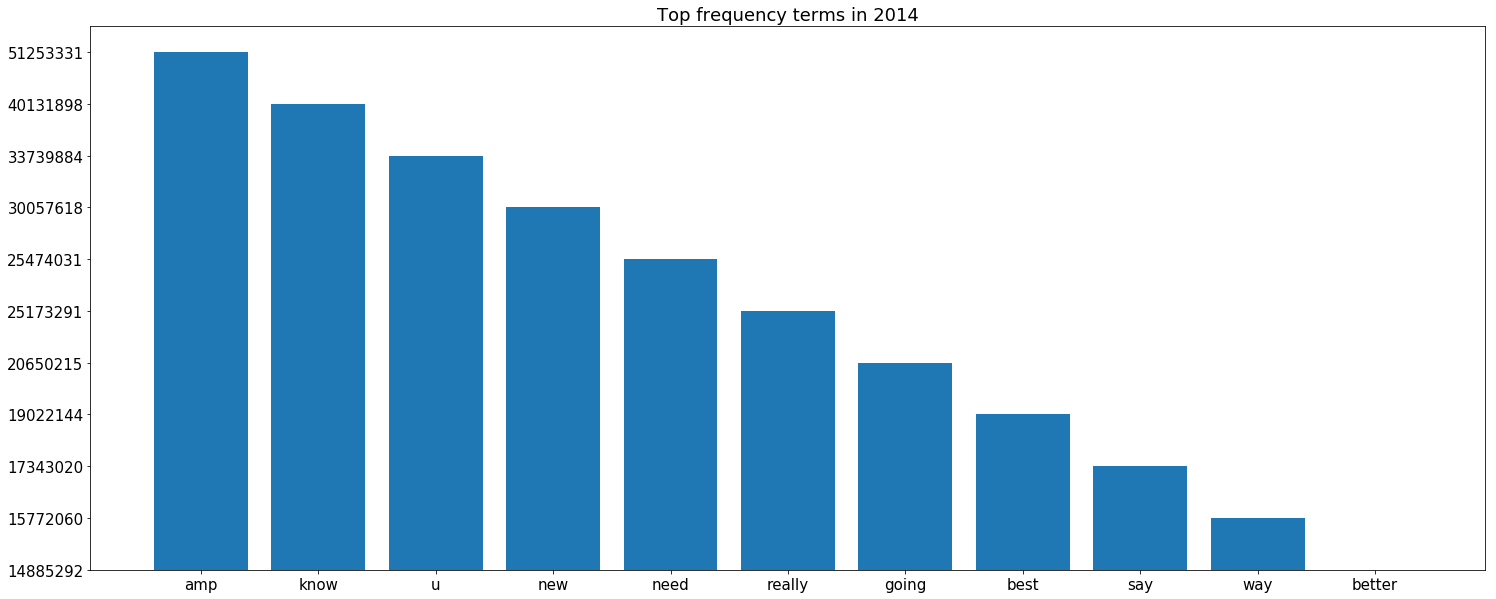

In [136]:
index_meaningful = [0, 2,3,4,5,6,8,9,10,11,14]
top_filtered_terms = np.array(top_filtered_terms)[index_meaningful]
indexes = np.arange(11) + 1
plt.rc('font', size=15)
plt.figure(figsize=(25,10))
x = [elem[0] for elem in top_filtered_terms]
y = [elem[1] for elem in top_filtered_terms]
plt.bar(indexes, x)
plt.xticks(indexes, y)
plt.title('Top frequency terms in 2014')
plt.show()

# 3) Semantic Analysis

#### a) Tokenization + Stopwords

In [ ]:
"Code (stopwords_2014.py) submit to cluster for the computation"

sc = SparkContext()
sqlContext = SQLContext(sc)
data = sc.textFile("/datasets/tweets-leon")

"""Select tweet by filtering"""
def selection_tweet(tweet):
    array = tweet.split("\t")
    if (len(array)==5):
        if (array[0] == 'en' and array[2][-4:]=='2014'): 
            return True
    return False

"""Remove punctuation, hashtags and urls"""
table = string.maketrans("","")
def punctuation(s):
    s = re.sub(r"@\S+", "", s)     #mention
    s = re.sub(r"http\S+", "", s)  #urls
    s = re.sub(r"#\S+", "", s)     #hashtag
    return s.translate(table, string.punctuation)

"encode tweet by mapping"
def encode_tweet(tweet):
    "Encode UTF-8"
    encoded = [t.encode("utf-8") for t in tweet.split("\t")]
    "Return ID and processed text"
    return Row(id=encoded[1], sentence=punctuation(encoded[4]).split(' '))


"Take a small dataset"
terms = data.filter(selection_tweet) \
            .map(encode_tweet)

"Transform to DF"
df_terms = sqlContext.createDataFrame(terms)  

"""Remove Stop-words"""
stopwords_rdd = sc.textFile('/user/khau/data/stopword.txt')
stopwords = stopwords_rdd.collect()
stopwords = stopwords[0].split(',')

remover = StopWordsRemover(inputCol="sentence", outputCol="filtered", stopWords=stopwords)
removed_stopwords = remover.transform(df_terms)

removed_stopwords.save('removed_stopwords_2014', mode='overwrite')

#### b) Lemmatization

In [ ]:
"Code (lemma_2014.py) submit to cluster for the computation"

sc = SparkContext()
sqlContext = SQLContext(sc)

"A function map all type of Noun to  wordnet.NOUN"
"E.x: Map ['NN', 'NNS', 'NNP', 'NNPS'] to wordnet.NOUN"
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

"A function lemmatizer a word with its POS"
lemmatiser = WordNetLemmatizer()
def lemmatization(row):
    sentence = row.filtered
    id_ = row.id
    if (len(sentence) == 0): # Nothing to lemmatiser
        return []
    else :
        tokens_pos = pos_tag(sentence)
        tokens_pos = [(w, get_wordnet_pos(p)) for (w,p) in tokens_pos]
        return Row(id=id_, lemmatized=[lemmatiser.lemmatize(w, pos=p) for (w,p) in tokens_pos if p != None and all(ord(char) < 128 for char in w)])


"A function filter any tweets that the contain is empty after removing stopwords and lemmatizing"
def filterRow(row) : return len(row.lemmatized) != 0


"Read stopwords dataframe"
removed_stopwords = sqlContext.read.load('removed_stopwords_2014')

"Drop useless column"
truncate_stopwords_df = removed_stopwords.drop('sentence')
truncate_stopwords_df.show()

"Transform in RDD for mapping"
rdd_stopwords = truncate_stopwords_df.rdd

"Do lemmatization"
rdd_lemma = rdd_stopwords.map(lemmatization) \
                         .filter(filterRow)

df_lemma = sqlContext.createDataFrame(rdd_lemma)


"Re-transform into DF for storing" 

df_lemma.save('lemmatization_2014', mode='overwrite')
df_lemma.show()

#### c) TF-IDF

In [ ]:
"Code (tfidf_2014.py) submit to cluster for the computation"

sc = SparkContext()
sqlContext = SQLContext(sc)



removed_stopwords = sqlContext.read.load('removed_stopwords_2014')
#truncate_df_sw = removed_stopwords.drop('sentence')

try:
    removed_stopwords = removed_stopwords.drop('sentence')
except:
    pass


"Parameter minDF: this term have to be appear in a specific nb of docs (1000 here)"
cv = CountVectorizer(inputCol="filtered", outputCol="vectors", minDF=1000.0)
count_vectorizer_model = cv.fit(removed_stopwords)
tf = count_vectorizer_model.transform(removed_stopwords)

try:
    tf = tf.drop('filtered')
except:
    pass

voca = count_vectorizer_model.vocabulary
vocabulary = sc.parallelize(voca)
vocabulary_df = sqlContext.createDataFrame(vocabulary.map(Row))
vocabulary_df.write.json("vocabulary_2014.txt")


idf = IDF(inputCol="vectors", outputCol="tfidf")
idfModel = idf.fit(tf)
tfidf = idfModel.transform(tf)

try:
    tfidf = tfidf.drop('vectors')
except:
    pass

tfidf.save('tfidf_2014', mode='overwrite')

#### d) LDA

In [ ]:
"Code (lda_2014.py) submit to cluster for the computation"

#sc = SparkContext()
#sqlContext = SQLContext(sc)

tfidf = sqlContext.read.load('/user/khau/tfidf_2014')

small_tfidf = tfidf.randomSplit([1.0, 5999.0], seed=3000000)

nbTopics= 15
maxIterations = 10
corpus = small_tfidf[0].select(F.col('id').cast("long"), 'tfidf').rdd.map(lambda x: [x[0], x[1]])
ldaModel = LDA.train(rdd=corpus, k=nbTopics)

df_topics = sqlContext.createDataFrame(ldaModel.describeTopics(10), ['terms','scores'])
df_topics.save('xxx', mode='overwrite')

#### e) Indeed, we have to take very small subset of our dataset for the computation

In [ ]:
sc = SparkContext()
sqlContext = SQLContext(sc)

removed_stopwords = sqlContext.read.load('removed_stopwords_2014')
#truncate_df_sw = removed_stopwords.drop('sentence')

try:
    removed_stopwords = removed_stopwords.drop('sentence')
except:
    pass


"Parameter minDF: this term have to be appear in a specific nb of docs (1000 here)"
cv = CountVectorizer(inputCol="filtered", outputCol="vectors", minDF=1000.0)
count_vectorizer_model = cv.fit(removed_stopwords)
tf = count_vectorizer_model.transform(removed_stopwords)

try:
    tf = tf.drop('filtered')
except:
    pass

print('################################# FINISH TF STAGE #############################################################################')


new_tf = tf.randomSplit([1.0, 3499.0], seed=2014)[0]

idf = IDF(inputCol="vectors", outputCol="tfidf")
idfModel = idf.fit(new_tf)
tfidf = idfModel.transform(new_tf)

try:
    tfidf = tfidf.drop('vectors')
except:
    pass

tfidf.show()

print('################################# FINISH TF-IDF STAGE #############################################################################')

nbTopics= 20
maxIterations = 10
optimizer = 'online'

corpus = tfidf.select(F.col('id').cast("long"), 'tfidf').rdd.map(lambda x: [x[0], x[1]])


ldaModel = LDA.train(rdd=corpus, k=nbTopics, maxIterations=maxIterations, optimizer=optimizer)

print('################################# FINISH LDA STAGE #############################################################################')

df_topics = sqlContext.createDataFrame(ldaModel.describeTopics(10), ['terms','scores'])
df_topics.save('topics_500k', mode='overwrite')

#### f) Visualization topics 

In [34]:
describeTopics = sqlContext.read.load('/user/khau/topics_100k')
topics = describeTopics.rdd.map(lambda x : (x['terms'], x['scores'])).collect()

In [4]:
vocabulary = sc.textFile('vocabulary_2014.txt').map(json.loads)
vocabulary = vocabulary.map(lambda x : x['_1']).collect()

In [41]:
nbColsPlot = 4
nbTopics=20
n_terms=10
def plot_topics(row):

    MAGIC_NUMBER = 50
    fontsize_init = MAGIC_NUMBER
    fig = plt.figure(figsize=(15, 7))
    for topic in range(row, min(row + nbColsPlot, nbTopics)):

        plt.subplot(1, nbColsPlot, topic%nbColsPlot + 1)
        plt.ylim(0, n_terms + .5)
        plt.xticks([]) 
        plt.yticks([])
        plt.title('Topic #{}'.format(topic+1), fontsize=30)
        words = topics[topic][0]
        scores = topics[topic][1]
        max_topic_score = max(scores)
        for word in range(len(words)):
            font_size = fontsize_init*scores[word]/max_topic_score
            font_size = min(font_size, MAGIC_NUMBER)
            font_size = max(font_size, 15)
            plt.text(0.05, n_terms-word-0.5, vocabulary[words[word]], fontsize=font_size) 
    plt.tight_layout()
    plt.show()

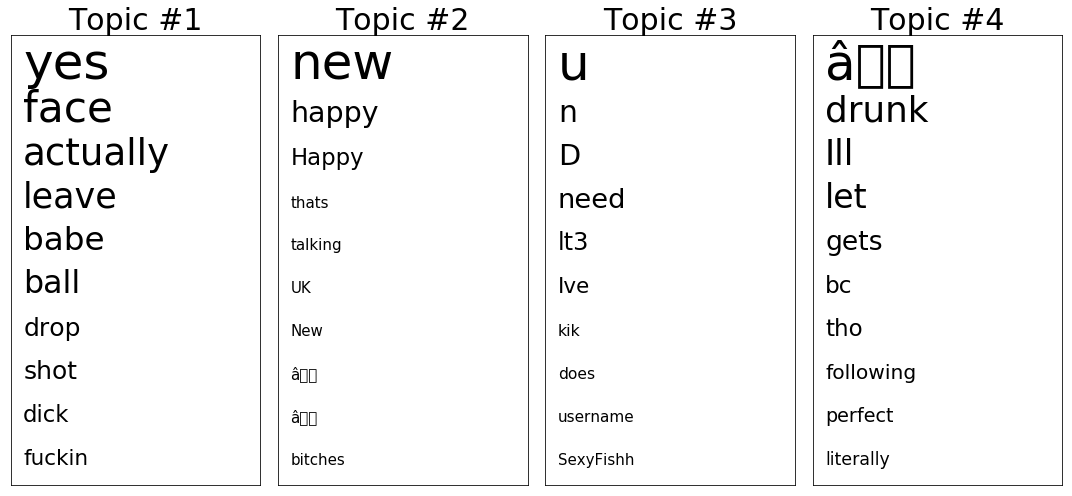

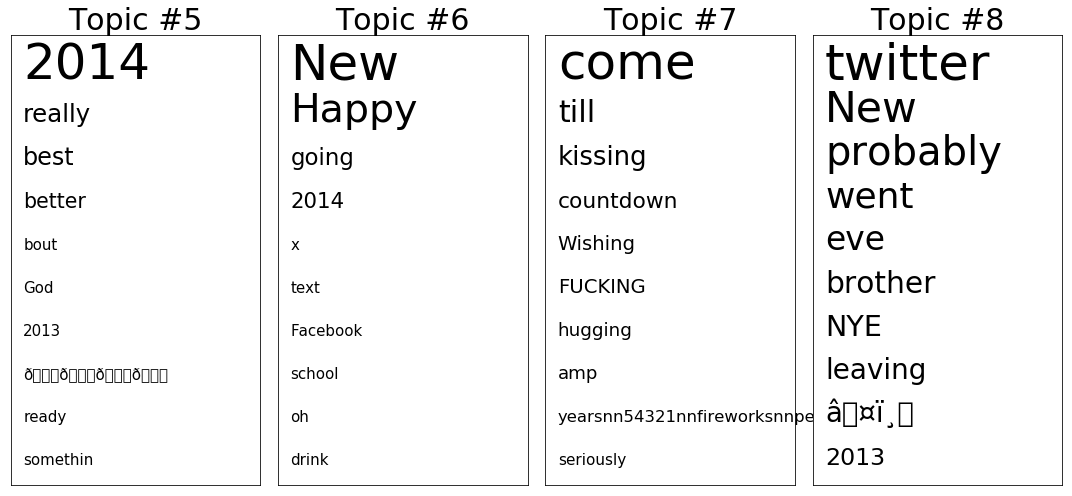

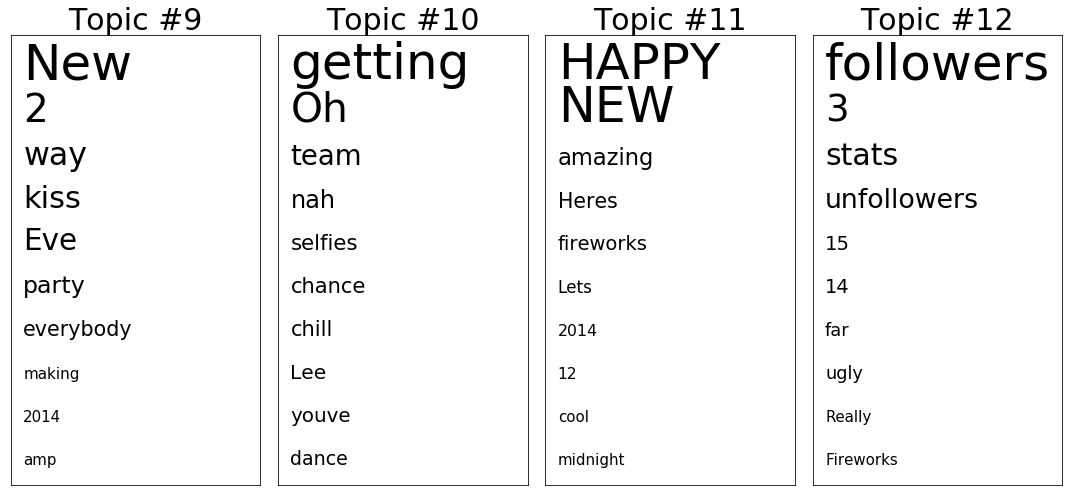

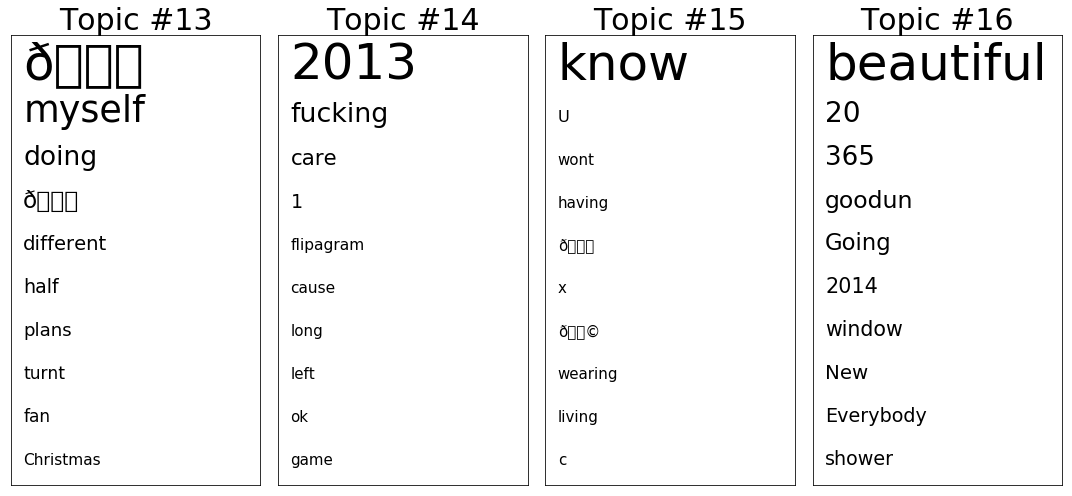

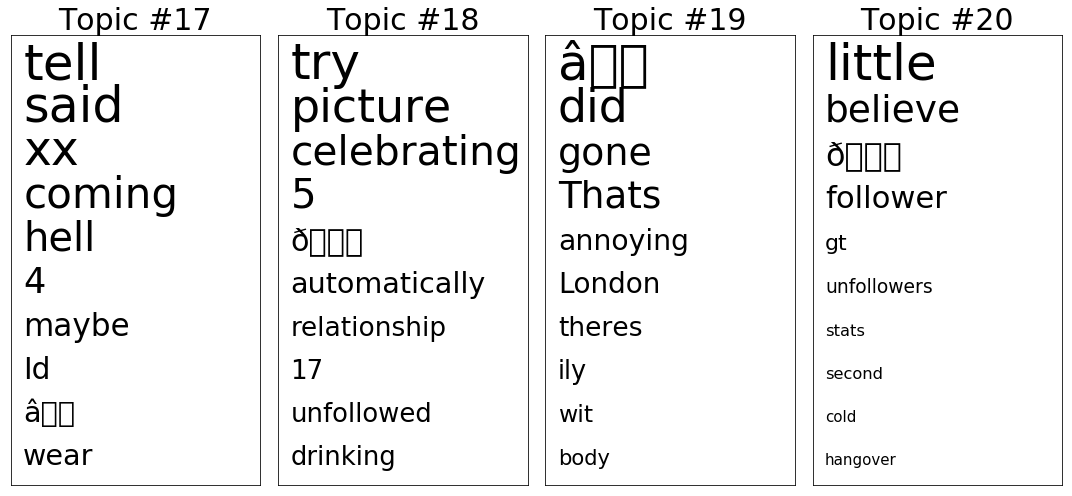

In [42]:
for row in range(0, nbTopics, nbColsPlot):
    plot_topics(row)

# 4 Trend detection

As soon as some new event is happening or a new trend is lanched on Internet, people create hashtag for it. So the best indication for a tread being created is the use of hashtag. This is why in order to detect trends we are going to look only at the hashtags in the tweet. More precisely we are looking at the top 10 most used hashtags each month and discuss the obtained results.

#### a) Hashtag frequncies per month 

In [ ]:
"""Code submited to the cluster(hashtag_month.py). We only change the month and submit 12 times this file."""
sc = SparkContext()
sqlContext = SQLContext(sc)
data = sc.textFile("/datasets/tweets-leon")

"""Select english tweets having all 5 fields from March 2014"""
def selection_tweet(tweet):
    array = tweet.split("\t")
    if (len(array)==5):
    	if (array[0] == 'en' and array[2][-4:]=='2014'and array[2].split(' ')[1] == 'Mar'):
        	return True
    return False

"""Extraxt the hashtag from the tweet"""
def extract_hash_tags(tweet):
    encoded = [t.encode("utf-8") for t in tweet.split("\t")]
    return [(part[1:],1) for part in encoded[4].split() if part.startswith('#')]

data_2014 = data.filter(selection_tweet)

hashtags = data_2014.flatMap(extract_hash_tags) \
               		.reduceByKey(lambda a,b : a+b) \
               		.sortBy(lambda wc: -wc[1])
        
hashtag_counts = sqlContext.createDataFrame(hashtags.map(lambda wc: Row(hashtag=wc[0], count=wc[1])))

hashtag_counts.write.json("/user/djambazo/hashtag_march.txt")


In [94]:
"""Load data per month"""
sqlContext = SQLContext(sc)
data_jan = sc.textFile("/user/djambazo/hashtag_jan.txt")
data_feb = sc.textFile("/user/djambazo/hashtag_february.txt")
data_mar = sc.textFile("/user/djambazo/hashtags_march.txt")
data_apr = sc.textFile("/user/djambazo/hashtag_apr.txt")
data_may = sc.textFile("/user/djambazo/hashtag_mayy.txt")
data_jun = sc.textFile("/user/djambazo/hashtag_june.txt")
data_jul = sc.textFile("/user/djambazo/hashtag_jul.txt")
data_aug = sc.textFile("/user/djambazo/hashtag_aug.txt")
data_sep = sc.textFile("/user/djambazo/hashtag_sep.txt")
data_oct = sc.textFile("/user/djambazo/hashtag_oct.txt")
data_nov = sc.textFile("/user/djambazo/hashtag_nov.txt")
data_dec = sc.textFile("/user/djambazo/hashtag_dec.txt")

In [95]:
"""Transform list to dictionary"""
def to_dictionary(list_):
    new_list = []
    for l in list_:
        l = ast.literal_eval(l)
        new_list.append(l)
    return new_list

In [96]:
"""Select the ten most used hashtags per month and transform them in dictionary"""
top10_jan = to_dictionary(data_jan.take(10))
top10_feb = to_dictionary(data_feb.take(10))
top10_mar = to_dictionary(data_mar.take(10))
top10_apr = to_dictionary(data_apr.take(10))
top10_may = to_dictionary(data_may.take(10))
top10_jun = to_dictionary(data_jun.take(10))
top10_jul = to_dictionary(data_jul.take(10))
top10_aug = to_dictionary(data_aug.take(10))
top10_sep = to_dictionary(data_sep.take(10))
top10_oct = to_dictionary(data_oct.take(10))
top10_nov = to_dictionary(data_nov.take(10))
top10_dec = to_dictionary(data_dec.take(10))

In [147]:
"""Plot the data in a bar plot"""
def plot_data(data, month, ax):
    x = [ e['count'] for e in data]
    y = [ e['hashtag'] for e in data]
    
    ax.tick_params(axis='both', which='both', labelsize=30)
    ax.bar(np.arange(len(y)),x, log=1)
    ax.set_xticks(np.arange(len(y)))
    ax.title.set_text("Top 10 hashtags for " + month)
    ax.title.set_size(40)
    ax.set_xticklabels(y, rotation = 45)


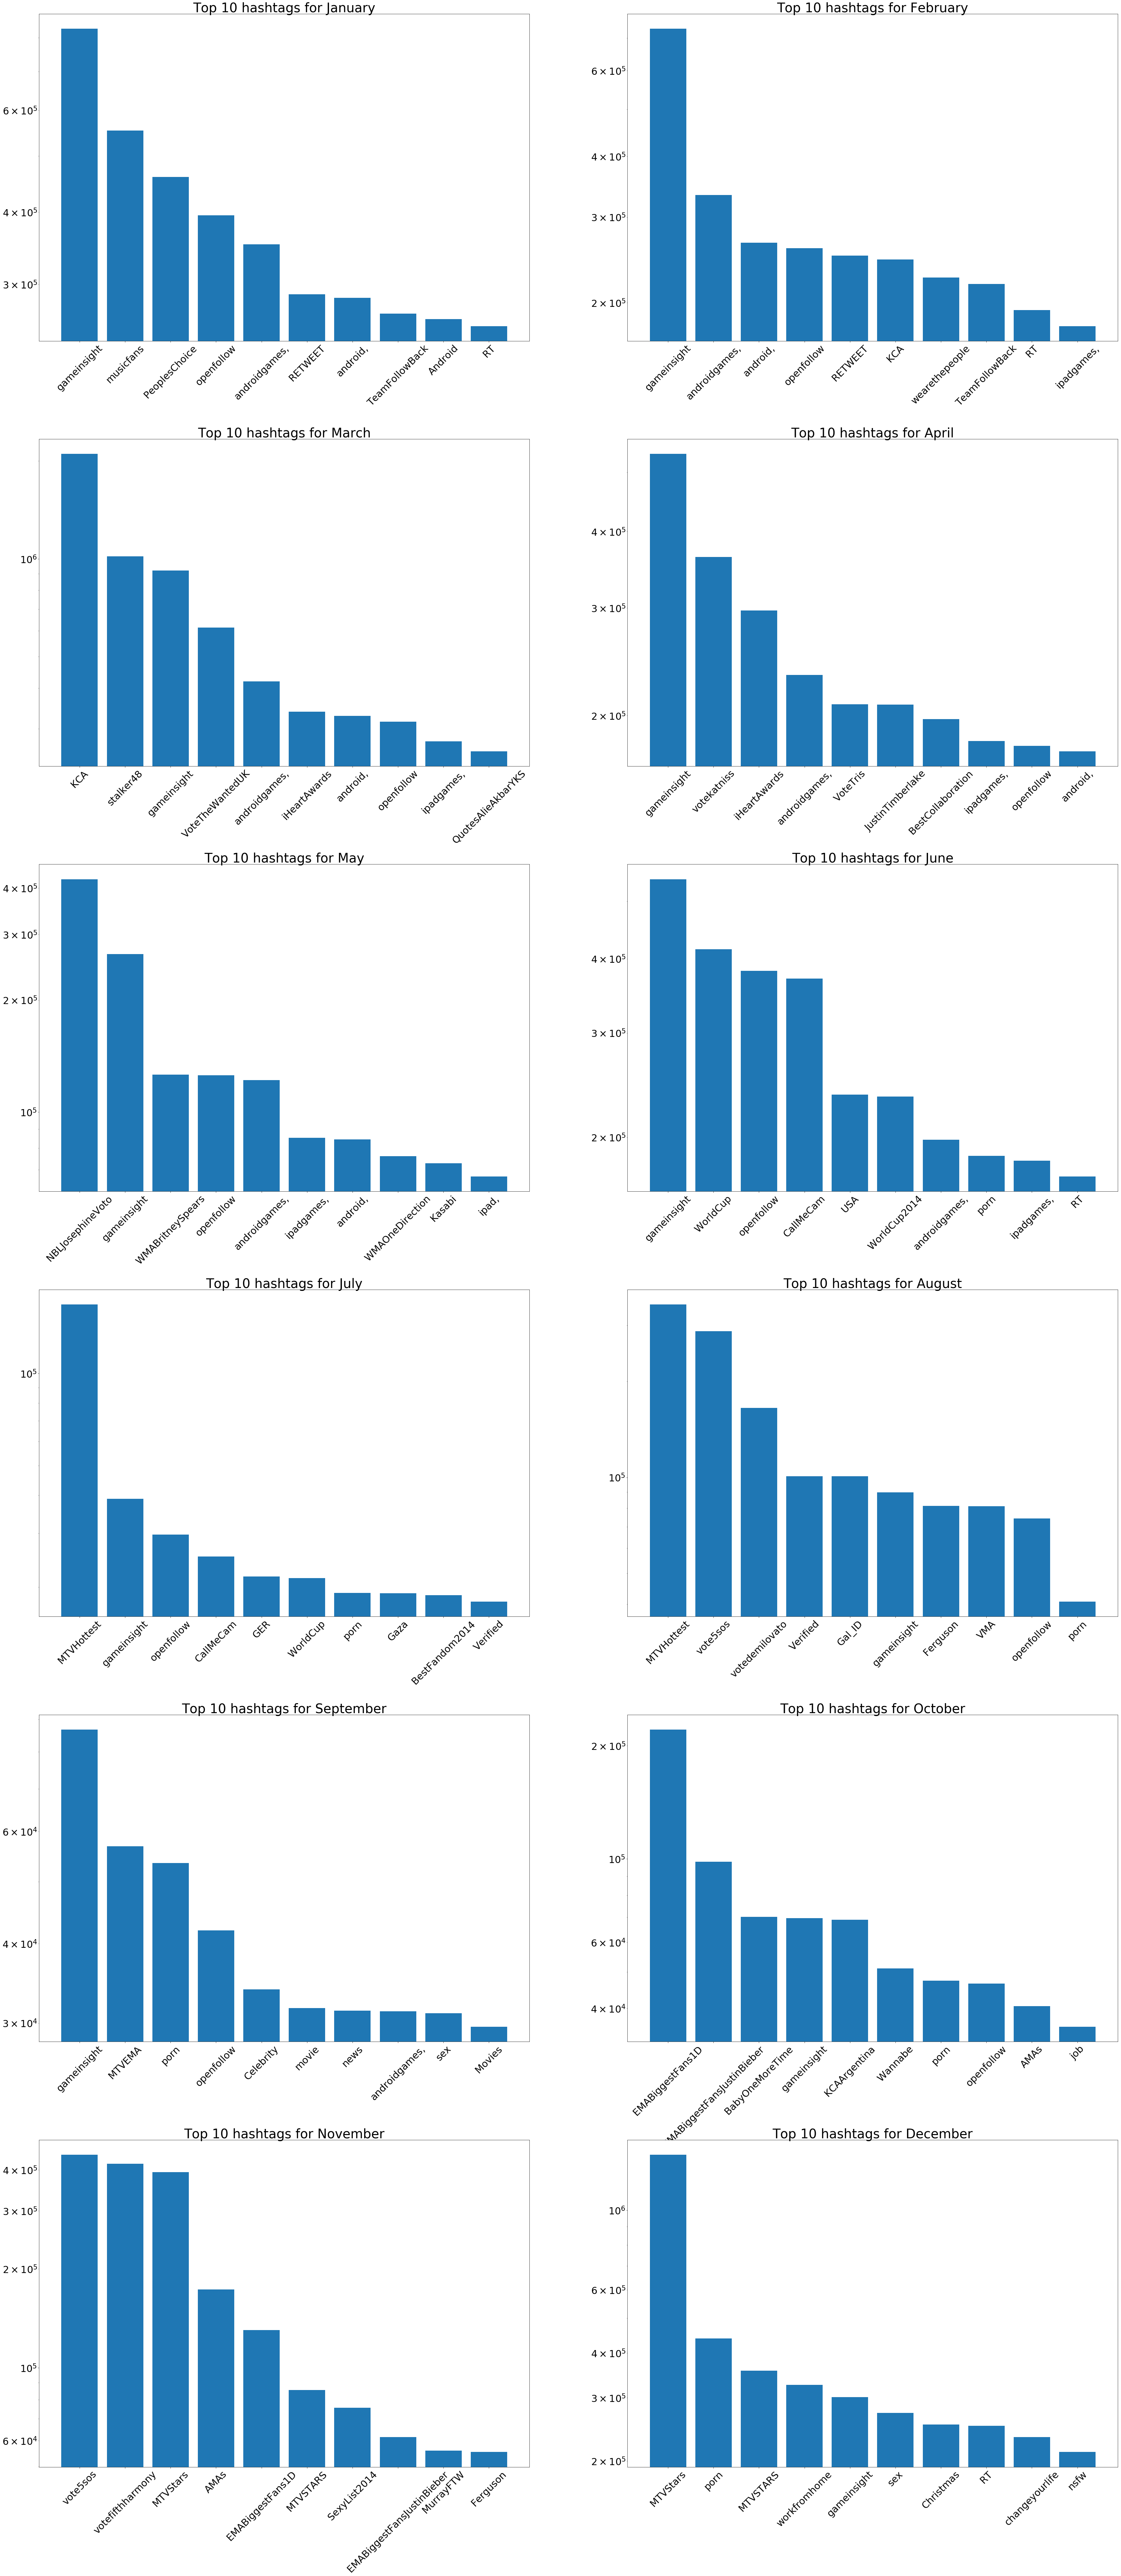

In [148]:
f, axs = plt.subplots(6,2,figsize=(60,140))
f.subplots_adjust(hspace=.3)
ax1 = plt.subplot(6, 2, 1)
plot_data(top10_jan,"January", ax1)
ax2 = plt.subplot(6, 2, 2)
plot_data(top10_feb,"February", ax2)
ax3 = plt.subplot(6, 2, 3)
plot_data(top10_mar,"March", ax3)
ax4 = plt.subplot(6, 2, 4)
plot_data(top10_apr,"April", ax4)
ax5 = plt.subplot(6, 2, 5)
plot_data(top10_may,"May", ax5)
ax6 = plt.subplot(6, 2, 6)
plot_data(top10_jun,"June", ax6)
ax7 = plt.subplot(6, 2, 7)
plot_data(top10_jul,"July", ax7)
ax8 = plt.subplot(6, 2, 8)
plot_data(top10_aug,"August", ax8)
ax9 = plt.subplot(6, 2, 9)
plot_data(top10_sep,"September", ax9)
ax10 = plt.subplot(6, 2, 10)
plot_data(top10_oct,"October", ax10)
ax11 = plt.subplot(6, 2, 11)
plot_data(top10_nov,"November", ax11)
ax12 = plt.subplot(6, 2, 12)
plot_data(top10_dec,"December", ax12)
plt.show()

In [149]:
top10_mar

[{'count': 2100923, 'hashtag': 'KCA'},
 {'count': 1017886, 'hashtag': 'stalker48'},
 {'count': 919572, 'hashtag': 'gameinsight'},
 {'count': 614745, 'hashtag': 'VoteTheWantedUK'},
 {'count': 419904, 'hashtag': 'androidgames,'},
 {'count': 338798, 'hashtag': 'iHeartAwards'},
 {'count': 329021, 'hashtag': 'android,'},
 {'count': 315332, 'hashtag': 'openfollow'},
 {'count': 274476, 'hashtag': 'ipadgames,'},
 {'count': 255812, 'hashtag': 'QuotesAlieAkbarYKS'}]

#### Comments on the results:
After lookig at the results we can see that there are different types of hashtags:

    -Hashtags about some events that are organised each year or each four years depending on the event. They usually appear sometime before the actual event and last usually a month after the event(depending on the popularity of the event). An example for this type of event can be elections, music shows, sport events like the world cup, chrismas... To understand better this kind of trend we will take a closer look at one of the hashtags in this group #KCA(Kids Choice Awards). This is a typical example of a short term highly popular trend that appears once per year. The first time it shows up in the top 10 is in February, as the 6th most popular hashtag. This is one month before the accual event on the 24th March 2014. Then in March, during the event, it becomes the most popular and it is used 2100923 times. The next month it disappear from the top 10 probably until February 2015.
    
    -Another type is the hashtags about a release of a new game, movie, application. They act similarly as the type previously described. The only difference is that they don't reappear after a certain period.  
     
    - and so on ...

#### b) Find the most popular users

In [ ]:
"""Code submited to the cluster(extract_RT.py)"""
sc = SparkContext()
sqlContext = SQLContext(sc)

data = sc.textFile("/datasets/tweets-leon")

"""Select tweet by filtering"""
def selection_tweet(tweet):
    array = tweet.split("\t")
    if (len(array)==5):
    	if (array[0] == 'en' and array[2][-4:]=='2014'):
        	return True
    return False
"""Extract the username of person who was retweeted"""
def extract_RT(tweet):
    encoded = [t.encode("utf-8") for t in tweet.split("\t")]
    return [(part[1:],1) for part in encoded[4].split() if (part.startswith('@') \
                                                            and part.endswith(":") \
                                                            and "RT" in encoded[4])]

data_2014 = data.filter(selection_tweet)

hashtags = data_2014.flatMap(extract_RT) \
               		.reduceByKey(lambda a,b : a+b) \
               		.sortBy(lambda wc: -wc[1])
        
hashtag_counts = sqlContext.createDataFrame(hashtags.map(lambda wc: Row(hashtag=wc[0], count=wc[1])))

hashtag_counts.write.json("hdfs:///user/djambazo/extract_ReT.txt")

In [150]:
"""Load data"""
sqlContext = SQLContext(sc)
data_RT = sc.textFile("/user/djambazo/extract_ReT.txt")

In [151]:
"""Take the ten most retweeted people in 2014"""
top10_RT_2014 = data_RT.take(10)
top10_RT_2014 = to_dictionary(top10_RT_2014)

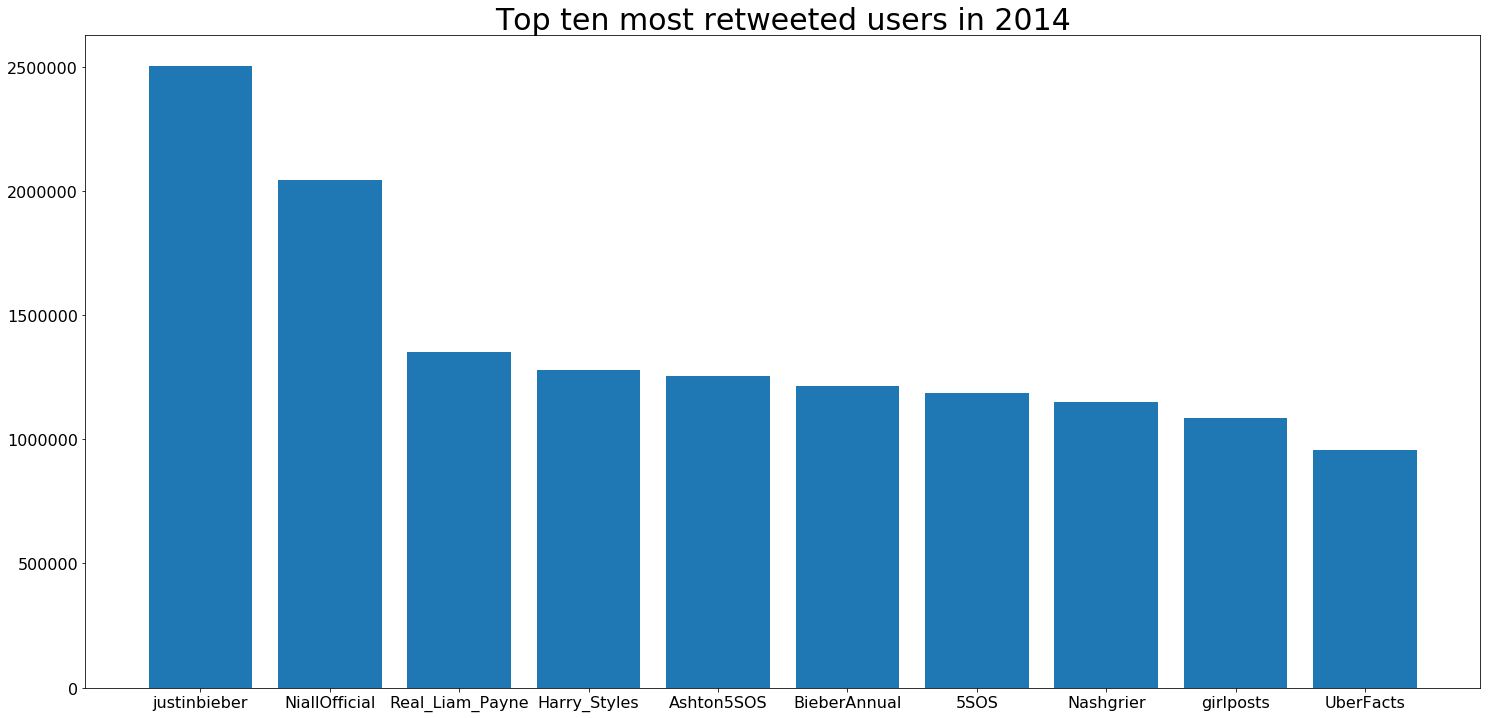

In [152]:
"""Plot the ten most retweeted users in 2014"""
nbTake = 10
indexes = np.arange(nbTake) + 1
x = [ e['count'] for e in top10_RT_2014]
y = [ e['hashtag'].replace(":","") for e in top10_RT_2014]
fig = plt.figure(figsize=(25,12))
plt.bar(indexes, x)
plt.xticks(indexes, y)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.title("Top ten most retweeted users in 2014",size=30)
fig.savefig('10_most_RT.png')
plt.show()

As expected the most popular users on Twitter are famous stars mostly from the music business. They are extreamly popular among the young public, mostly teenagers. 